In [1]:
import matplotlib.pyplot as plt
import nengo
import nengo_dl
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import collections

import nengo_loihi

import _init_paths

from configs.exp_configs import tf_exp_cfg as tf_cfg, nengo_dl_cfg as ndl_cfg
from utils.base_utils.data_prep_utils import get_batches_of_exp_dataset, get_exp_dataset
from utils.base_utils.exp_utils import get_shuffled_lists_in_unison
from utils.nengo_dl_utils import get_nengo_dl_model
from utils.nengo_loihi_utils import (
    get_loihi_adapted_avam_net_for_2x2_max_pooling, get_loihi_adapted_max_pool_global_net)

# Checking Global AVAM MaxPool net on Loihi

In [2]:
rows, cols, num_chnls = 8, 8, 3
net = get_loihi_adapted_max_pool_global_net((num_chnls, rows, cols), max_rate=250, synapse=0.005)

vec = np.arange(rows * cols * num_chnls)
with net:
  inp_node = nengo.Node(vec)
  nengo.Connection(inp_node, net.inputs, synapse=None)
  ens = nengo.Ensemble(n_neurons=(rows*cols*num_chnls)//4, dimensions=1, label="OUT ENS")
  nengo.Connection(net.output, ens.neurons, synapse=None)
  out_probe = nengo.Probe(net.output)

In [3]:
with nengo_loihi.Simulator(net) as loihi_sim:
  loihi_sim.run(0.1)

/homes/rgaurav/nengo-loihi/nengo_loihi/passthrough.py:118: UserWarning: Combining two Lowpass synapses, this may change the behaviour of the network (set `remove_passthrough=False` to avoid this).
  warnings.warn(
/homes/rgaurav/nengo-loihi/nengo_loihi/builder/ensemble.py:154: UserWarning: NengoLoihi does not support initial values for 'voltage' being non-zero on LIF neurons. On the chip, all values will be initialized to zero.
  warnings.warn(
/homes/rgaurav/nengo-loihi/nengo_loihi/block.py:214: UserWarning: tau_s is currently 0.005, which is smaller than 0.01. Overwriting tau_s with 0.01.
  warnings.warn(
/homes/rgaurav/nengo-loihi/nengo_loihi/block.py:208: UserWarning: tau_s is already set to 0.01, which is larger than 0.005. Using 0.01.
  warnings.warn(
/homes/rgaurav/nengo-loihi/nengo_loihi/builder/discretize.py:477: UserWarning: Lost 5 extra bits in weight rounding
  warnings.warn("Lost %d extra bits in weight rounding" % (-s2,))
/homes/rgaurav/nengo-loihi/nengo_loihi/builder/dis

BuildError: Input axons (74016) exceeded max (4096) in LoihiBlock(<Ensemble "OUT ENS">[0:2:1])

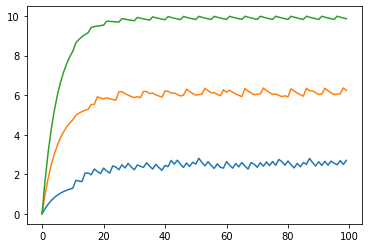

In [6]:
plt.plot(loihi_sim.data[out_probe])

In [14]:
with nengo.Network() as net1:
  inpt = nengo.Node(np.ones(12))
  ens = nengo.Ensemble(n_neurons=12, dimensions=1)
  nengo.Connection(inpt, ens.neurons, synapse=None)

with nengo_loihi.Simulator(net1) as l_sim1:
  l_sim1.run(0.1)

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.178:41683
INFO:DRV:      Host server up..............Done 0.91s
INFO:DRV:      Encoding axons/synapses.....Done 3.38ms
INFO:DRV:      Compiling Embedded snips....Done 0.43s
INFO:DRV:      Compiling MPDS Registers....Done 0.80ms
INFO:HST:  Args chip=0 cpu=0 /homes/rgaurav/nxsdk_1_nengo_loihi/lib/python3.8/site-packages/nxsdk/driver/compilers/../../../temp/1626712821.8404562/launcher_chip0_lmt0.bin --chips=1 --remote-relay=0 
INFO:HST:  Nx...
INFO:DRV:      Booting up..................Done 1.25s
INFO:DRV:      Encoding probes.............Done 0.76ms
INFO:DRV:      Transferring probes.........Done 8.82ms
INFO:DRV:      Configuring registers.......Done 0.05s
INFO:DRV:      Transferring spikes.........Done 0.04s
INFO:DRV:      Executing...................Done 0.01s
INFO:DRV:      Processing timeseries.......Done 0.69ms
INFO:DRV:  Executor: 100 timesteps.........Done 0.12s
INFO:HST:  chip=0 cpu=0 halted, status=0x

# Checking Loihi AVAM MaxPooling

In [2]:
P1, P2, P3, P4 = 6, 8, 4, 7
def get_spikes(t):
  int_t = int(t*1000)
  return np.array([
   1.0 if int_t%P1 else 0.0,
   1.0 if int_t%P2 else 0.0,
   1.0 if int_t%P3 else 0.0,
   1.0 if int_t%P4 else 0.0
  ])

## CHECK THE OUTPUT OF MIN ISI NEURON

INFO:DRV:  SLURM is being run in background


/homes/rgaurav/nengo-loihi/nengo_loihi/builder/ensemble.py:154: UserWarning: NengoLoihi does not support initial values for 'voltage' being non-zero on LIF neurons. On the chip, all values will be initialized to zero.
  warnings.warn(


INFO:DRV:  Connecting to 10.212.98.108:36137
INFO:DRV:      Host server up..............Done 0.20s
INFO:DRV:      Encoding axons/synapses.....Done 1.66ms
INFO:DRV:      Compiling Embedded snips....Done 0.36s
INFO:DRV:      Compiling MPDS Registers....Done 0.91ms
INFO:HST:  Args chip=0 cpu=0 /homes/rgaurav/nxsdk_1_nengo_loihi/lib/python3.8/site-packages/nxsdk/driver/compilers/../../../temp/1626893246.019148/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 
INFO:HST:  Nx...
INFO:DRV:      Booting up..................Done 0.65s
INFO:DRV:      Encoding probes.............Done 0.95ms
INFO:DRV:      Transferring probes.........Done 2.96ms
INFO:DRV:      Configuring registers.......Done 4.06ms
INFO:DRV:      Transferring spikes.........Done 4.74ms
INFO:DRV:      Executing...................Done 1.95ms
INFO:DRV:      Processing timeseries.......Done 1.04ms
INFO:DRV:  Executor: 100 timesteps.........Done 0.02s
INFO:HST:  chip=0 cpu=0 halted, status=0x0


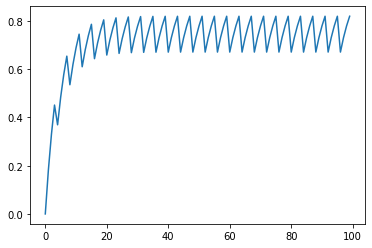

In [3]:
def gen_spike(t):
  int_t = int(t*1000)
  return 1.0 if int_t%4 else 0

with nengo.Network() as sample_net:
  inp = nengo.Node(gen_spike)
  ens = nengo.Ensemble(n_neurons=1, dimensions=1)
  nengo.Connection(inp, ens.neurons, synapse=0.005)
  
  probe_inp = nengo.Probe(inp, attr="output", synapse=0.005)
  
with nengo_loihi.Simulator(sample_net) as l_sim:
  l_sim.run(0.1)

plt.plot(l_sim.data[probe_inp])

In [4]:
net = get_loihi_adapted_avam_net_for_2x2_max_pooling(radius=3, synapse=0.005, sf=1, max_rate=250)
with net:
  inpt = nengo.Node(get_spikes)
  nengo.Connection(inpt, net.inputs, synapse=0.005)
  otp_probe = nengo.Probe(net.otpt_neuron.neurons, synapse=0.005)

In [5]:
with nengo_loihi.Simulator(net) as loihi_sim:
  loihi_sim.run(0.1)

/homes/rgaurav/nengo-loihi/nengo_loihi/passthrough.py:118: UserWarning: Combining two Lowpass synapses, this may change the behaviour of the network (set `remove_passthrough=False` to avoid this).
  warnings.warn(
/homes/rgaurav/nengo-loihi/nengo_loihi/block.py:214: UserWarning: tau_s is currently 0.005, which is smaller than 0.01. Overwriting tau_s with 0.01.
  warnings.warn(
/homes/rgaurav/nengo-loihi/nengo_loihi/block.py:208: UserWarning: tau_s is already set to 0.01, which is larger than 0.005. Using 0.01.
  warnings.warn(


INFO:DRV:  SLURM is being run in background


/homes/rgaurav/nengo-loihi/nengo_loihi/builder/discretize.py:477: UserWarning: Lost 4 extra bits in weight rounding
  warnings.warn("Lost %d extra bits in weight rounding" % (-s2,))


INFO:DRV:  Connecting to 10.212.98.108:33155
INFO:DRV:      Host server up..............Done 0.18s
INFO:DRV:      Encoding axons/synapses.....Done 7.48ms
INFO:DRV:      Compiling Embedded snips....Done 0.33s
INFO:DRV:      Compiling MPDS Registers....Done 0.96ms
INFO:HST:  Args chip=0 cpu=0 /homes/rgaurav/nxsdk_1_nengo_loihi/lib/python3.8/site-packages/nxsdk/driver/compilers/../../../temp/1626893247.961146/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 
INFO:HST:  Nx...
INFO:DRV:      Booting up..................Done 0.65s
INFO:DRV:      Encoding probes.............Done 0.93ms
INFO:DRV:      Transferring probes.........Done 3.13ms
INFO:DRV:      Configuring registers.......Done 0.01s
INFO:DRV:      Transferring spikes.........Done 0.06s
INFO:DRV:      Executing...................Done 0.01s
INFO:DRV:      Processing timeseries.......Done 2.17ms
INFO:DRV:  Executor: 100 timesteps.........Done 0.09s
INFO:HST:  chip=0 cpu=0 halted, status=0x0


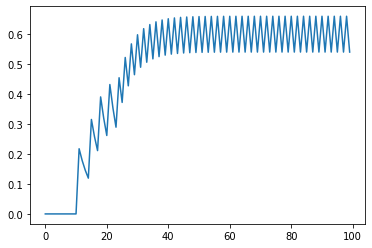

In [6]:
plt.plot(loihi_sim.data[otp_probe])

# #########################################################

In [2]:
ndl_model, ngo_probes_lst = get_nengo_dl_model(
    (32, 32, 3), tf_cfg, ndl_cfg, mode="test", num_clss=10,
    max_to_avg_pool=False, include_layer_probes=True, channels_first=False)

/homes/rgaurav/nxsdk_1_nengo_loihi/lib/python3.8/site-packages/nengo_dl/converter.py:324: UserWarning: Cannot convert max pooling layers to native Nengo objects; consider setting max_to_avg_pool=True to use average pooling instead. Falling back to TensorNode.
  warnings.warn(


In [3]:
probe = ngo_probes_lst[1:-1][0]
print(probe)

<Probe of 'output' of <Neurons of <Ensemble "conv2d_2.0">>>


In [4]:
probe.obj.ensemble.label

'conv2d_2.0'

In [3]:
train_x, train_y, _, _ = get_exp_dataset(tf_cfg["dataset"])

In [5]:
train_idg = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=0.1, height_shift_range=0.1, rotation_range=20,
    horizontal_flip=True, data_format="channels_first")
train_idg.fit(train_x, seed=0)

In [3]:
train_batches = get_batches_of_exp_dataset(ndl_cfg, ndl_model, ngo_probes_lst, is_test=False)

# ###############################################################

In [2]:
inp = tf.keras.Input(shape=(1, 28, 28), name="input")

to_spikes = tf.keras.layers.Conv2D(
  filters=3, # 3 RGB Neurons per pixel.
  kernel_size=(1, 1), strides=(1, 1), activation=tf.nn.relu,
  use_bias=False, # Default is True.
  data_format="channels_first", name="to-spikes")(inp)

################################ ON-CHIP LAYERS ##################################
conv0 = tf.keras.layers.Conv2D(
  filters=8, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,
  use_bias=False, data_format="channels_first", name="conv0")(to_spikes)

avgp0 = tf.keras.layers.AveragePooling2D(
  pool_size=(2, 2), padding="valid", data_format="channels_first",
  name="AvgPool0")(conv0)

conv1 = tf.keras.layers.Conv2D(
  filters=16, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,
  use_bias=False, data_format="channels_first", name="conv1")(avgp0)

flatten = tf.keras.layers.Flatten(name="flatten")(conv1)
dense0 = tf.keras.layers.Dense(64, activation=tf.nn.relu, name="dense0")(flatten)

In [3]:
dense1 = tf.keras.layers.Dense(10, name="dense1")(dense0)
model = tf.keras.Model(inputs=inp, outputs=dense1)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1, 28, 28)]       0         
_________________________________________________________________
to-spikes (Conv2D)           (None, 3, 28, 28)         3         
_________________________________________________________________
conv0 (Conv2D)               (None, 8, 26, 26)         216       
_________________________________________________________________
AvgPool0 (AveragePooling2D)  (None, 8, 13, 13)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 11, 11)        1152      
_________________________________________________________________
flatten (Flatten)            (None, 1936)              0         
_________________________________________________________________
dense0 (Dense)               (None, 64)                123968

In [7]:
nengo_converter = nengo_dl.Converter(
    model,
    scale_firing_rates=400,
    swap_activations={tf.nn.relu: nengo_loihi.neurons.LoihiSpikingRectifiedLinear()},
    synapse=0.005,
)
net = nengo_converter.net

In [8]:
with net:
    nengo_loihi.add_params(net)  # allow on_chip to be set
    # Both of the following lines works.
    #net.config[nengo_converter.layers[to_spikes].ensemble].on_chip = False
    net.config[nengo_converter.layers[nengo_converter.model.layers[1]].ensemble].on_chip = False

In [12]:
loihi_sim = nengo_loihi.Simulator(net, target="sim", remove_passthrough=False)

BuildError: Conv2D transforms not supported for off-chip to on-chip connections where `pre` is not a Neurons object.

In [5]:
mp_lyr_otpt = np.load("/home/rgaurav/projects/def-anarayan/rgaurav/spiking_investigation/experiment_outputs/cifar10/"
                      "model_1/ndl_train_test_results/ndl_test_only_results/sim_lyr_probes_otpt.npy", allow_pickle=True)

In [6]:
ti_0_mp_output = mp_lyr_otpt.item()["max_pooling2d"][0]

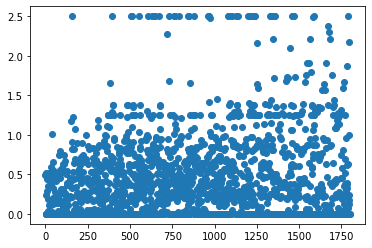

In [18]:
ti_mp_output = mp_lyr_otpt.item()["max_pooling2d"][0]
plt.scatter(np.arange(0, 1800), np.mean(ti_mp_output[-10:, :], axis=0))

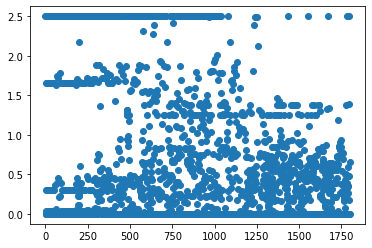

In [19]:
ti_mp_output = mp_lyr_otpt.item()["max_pooling2d"][1]
plt.scatter(np.arange(0, 1800), np.mean(ti_mp_output[-10:, :], axis=0))

In [2]:
model, probes = get_nengo_dl_model((32, 32, 3), tf_cfg, ndl_cfg, mode="train", num_clss=10)

RG: Input shape: (32, 32, 3)


/home/rgaurav/miniconda3/envs/nengo-tf/lib/python3.7/site-packages/nengo_dl/converter.py:326: UserWarning: Layer type <class 'tensorflow.python.keras.layers.core.Dropout'> does not have a registered converter. Falling back to TensorNode.
  % (error_msg + ". " if error_msg else "")


In [3]:
model.model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 4)         12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 8)         288       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         576       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 16)        1152      
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               295040

# ################# NENGO RELAY NEURON #########

In [82]:
with nengo.Network() as net:
  inpt = nengo.Node(lambda t: 10 if int(t*1000)%4==0 else 0.0)
  ens = nengo.Ensemble(n_neurons=1, dimensions=1, radius=2.5,
                       neuron_type=nengo_loihi.neurons.LoihiSpikingRectifiedLinear(amplitude=5/1000),
                      intercepts=[0], max_rates=[1000])
  nengo.Connection(inpt, ens.neurons, synapse=0.005)
  n_probe = nengo.Probe(ens.neurons[0], synapse=0.005)
  inpt_probe = nengo.Probe(inpt, synapse=0.005)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

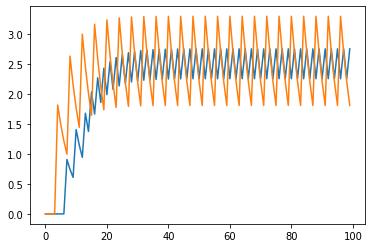

In [80]:
with nengo.Simulator(net) as ngo_sim:
  ngo_sim.run(0.1)
  
plt.plot(ngo_sim.data[n_probe])
plt.plot(ngo_sim.data[inpt_probe])

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.178:44205
INFO:DRV:      Host server up..............Done 0.75s
INFO:DRV:      Encoding axons/synapses.....Done 1.55ms
INFO:DRV:      Compiling Embedded snips....Done 0.60s
INFO:DRV:      Compiling MPDS Registers....Done 1.57ms
INFO:HST:  Args chip=0 cpu=0 /homes/rgaurav/nxsdk_1_nengo_loihi/lib/python3.8/site-packages/nxsdk/driver/compilers/../../../temp/1626890572.3296692/launcher_chip0_lmt0.bin --chips=1 --remote-relay=0 
INFO:HST:  Nx...
INFO:DRV:      Booting up..................Done 1.08s
INFO:DRV:      Encoding probes.............Done 0.75ms
INFO:DRV:      Transferring probes.........Done 0.10s
INFO:DRV:      Configuring registers.......Done 8.90ms
INFO:DRV:      Transferring spikes.........Done 7.64ms
INFO:DRV:      Executing...................Done 0.02s
INFO:DRV:      Processing timeseries.......Done 4.64ms
INFO:DRV:  Executor: 100 timesteps.........Done 0.15s
INFO:HST:  chip=0 cpu=0 halted, status=0

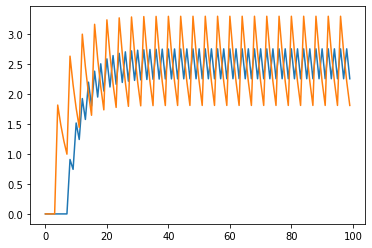

In [83]:
with nengo_loihi.Simulator(net) as loihi_sim:
  loihi_sim.run(0.1)
  
plt.plot(loihi_sim.data[n_probe])
plt.plot(loihi_sim.data[inpt_probe])